# 1.Sử dụng các checkpoint đã huấn luyện để đoán nhận dữ liệu

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

In [1]:
#@title Nhập tên các bộ dữ liệu đoán nhận
# là bộ dữ liệu hiện tại, được tạo trong lần đoán nhận này (tên file là lần đoán nhận này)
# sẽ trộn cả 2 bộ để đem ra đoán, nếu muốn đoán nhận từng bộ riêng lẻ thì comment lại bộ khác
# dùng model hiện tại để doán nhận bộ dữ liệu hiện tại => 2 bộ dưới là 2 bộ dữ liệu hiện tại
L_source = ",".join(map(lambda x: f"/cic/dataset/featured_extracted/{x}/", [
    'nsm_infer_12907_v3',
    #'nsm-2023w09-02-label',
    #'nsm-2023w09-01-label',
    #'nsm-2023w08-dos-01-label',
]))

In [2]:
#@title Nhập tên các checkpoint
# dòng đầu tiên, 2023W0702, là checkpoint hiện tại
# dòng thứ 2 trở đi, 2023W0701 ...., là các checkpoint quá khứ để đoán dữ liệu hiện tại là 2023W0702
# mỗi dòng, checkpoint là một model version được tải lên để đoán nhận các bộ dữ liệu L_source ở bên trên.
checkpoints = [
    '2023W0904',
    '2023W0902',
    '2023W0901',
    #'2023W0801',
    #'2023W0704',
    #'2023W0703',
    #'2023W0702',
    #'2023W0701',
    #'2023W0604',
]

# 2.PREPARATION

In [3]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-03-11 03:10:23.846454: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 03:10:26.078383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13129 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-03-11 03:10:26.079846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13129 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-03-11 03:10:26.081307: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13129 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [28]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import json
import ray
import pandas as pd
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from tensorflow import keras

import common
from anomaly_normalization import LABEL, SRC_IP, SRC_PORT, DST_IP, DST_PORT, TIMESTAMP, ALL_FEATURES
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, IMG, read_csv_in_dir_label_string

run, client = common.init_experiment(name='notebook')


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [36]:
#@title Generate an input sequence
n_timesteps_in = 100  #@param {type:"integer"}
n_features = 79   #@param {type:"integer"}

L_data: Dataset = read_csv_in_dir_label_string(L_source)
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
features = features[0: n_features]
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))

total_size = int(L_count.sum()['count()']) // n_timesteps_in
predict_size = total_size
print ('features=', features)
print ('Lpadding_features=', Lpadding_features)
print ('total_size = ', total_size)
print ('predict_size = ', predict_size)


L_predict = DataFrame.from_records(L_data.take(predict_size  * n_timesteps_in))
L_predict[Lpadding_features] = 0
LX_predict = L_predict[features].to_numpy().reshape(predict_size, n_timesteps_in, n_features)
Ly_predict = L_predict[LABEL].apply(lambda x: 0 if x in ['', 'Benign'] else 1).to_numpy().reshape((predict_size, n_timesteps_in))

2023-03-11 03:37:39,465	WARNING read_api.py:256 -- The number of blocks in this dataset (15) limits its parallelism to 15 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 34.24it/s]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

In [38]:
L_count

,label,count()
0,Anomaly,70
1,Benign,340730


## Data preview

### L_train preview

In [39]:
L_predict[[LABEL, TIMESTAMP, SRC_IP, SRC_PORT, DST_IP, DST_PORT, *features]]

,label,timestamp,src_ip,src_port,dst_ip,dst_port,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags,fwd_seg_size_avg,fwd_seg_size_min,fwd_urg_flags,idle_max,idle_mean,idle_min,idle_std,init_bwd_win_byts,init_fwd_win_byts,pkt_len_max,pkt_len_mean,pkt_len_min,pkt_len_std,pkt_len_var,pkt_size_avg,protocol,psh_flag_cnt,rst_flag_cnt,src_port,subflow_bwd_byts,subflow_bwd_pkts,subflow_fwd_byts,subflow_fwd_pkts,syn_flag_cnt,tot_bwd_pkts,tot_fwd_pkts,totlen_bwd_pkts,totlen_fwd_pkts,urg_flag_cnt
0,Benign,2023-03-05 12:19:39,10.0.2.182,22.0,172.18.12.113,50240.0,8.0,0.0,0.0,0.0,0.0,12430.0,588.0,128.0,16286.0,15634.666667,15116.0,596.175589,46904.0,84.0,63.000000,0.0,42.000000,7.0,80.961826,0.0,63.000000,0.0,0.0,1.0,50240.0,0.0,1.0,11901.388495,49406.0,13130.0,7058.000000,2103.0,5626.050035,161.923653,3.0,0.0,0.0,128.0,16259.0,15767.666667,15412.0,439.495544,47303.0,84.0,84.000000,84.0,0.000000,0.0,80.961826,1.0,84.000000,32.0,0.0,1.677950e+15,1.677950e+15,1.677950e+15,0.0,501.0,254.0,84.0,74.666667,0.0,28.000000,784.000000,84.000000,6.0,7.0,0.0,22.0,31.0,0.0,42.0,0.0,0.0,4.0,4.0,252.0,336.0,0.0
1,Benign,2023-03-05 12:19:39,10.0.2.182,22.0,172.18.12.113,50252.0,13.0,0.0,0.0,0.0,0.0,11765.0,924.0,192.0,16262.0,15764.200000,15166.0,475.559881,78821.0,84.0,70.000000,0.0,34.292856,11.0,73.776237,0.0,70.000000,0.0,0.0,0.0,50252.0,0.0,1.0,11361.540448,81327.0,13465.0,6777.250000,53.0,5632.834845,159.848513,5.0,0.0,0.0,212.0,16145.0,13545.666667,2742.0,5297.743356,81274.0,84.0,72.000000,0.0,31.749016,0.0,86.072276,1.0,72.000000,20.0,0.0,1.677950e+15,1.677950e+15,1.677950e+15,0.0,501.0,255.0,84.0,72.000000,0.0,30.503468,930.461538,77.538462,6.0,11.0,1.0,22.0,32.0,0.0,38.0,0.0,0.0,6.0,7.0,420.0,504.0,0.0
2,Benign,2023-03-05 12:19:39,10.0.2.182,22.0,172.18.12.113,50268.0,19.0,0.0,0.0,0.0,0.0,11085.0,1264.0,288.0,23693.0,14635.375000,5009.0,6293.793427,117083.0,84.0,69.333333,0.0,28.284271,16.0,75.298685,0.0,69.333333,0.0,0.0,0.0,50268.0,0.0,1.0,10575.281952,119524.0,18962.0,6640.222222,524.0,5377.704043,158.963890,8.0,0.0,0.0,308.0,22058.0,13222.222222,2536.0,6413.577800,119000.0,84.0,64.000000,0.0,35.175749,0.0,83.665205,0.0,64.000000,20.0,0.0,1.677950e+15,1.677950e+15,1.677950e+15,0.0,501.0,256.0,84.0,63.200000,0.0,33.931200,1151.326316,66.526316,6.0,16.0,1.0,22.0,32.0,0.0,33.0,0.0,0.0,9.0,10.0,624.0,640.0,0.0
3,Benign,2023-03-05 12:19:39,172.18.12.113,50276.0,10.0.2.182,22.0,20.0,0.0,0.0,0.0,0.0,6609.0,1280.0,288.0,31472.0,16709.375000,3750.0,7951.041404,133675.0,84.0,71.111111,0.0,28.689913,17.0,45.961045,0.0,71.111111,0.0,0.0,0.0,22.0,0.0,1.0,6536.682021,195818.0,59977.0,10306.210526,21.0,13462.984057,102.135657,9.0,0.0,0.0,352.0,62240.0,19581.800000,21.0,17561.401816,195818.0,84.0,58.181818,0.0,35.614093,0.0,56.174611,0.0,58.181818,32.0,0.0,1.677950e+15,1.677950e+15,1.677950e+15,0.0,259.0,501.0,84.0,60.952381,0.0,34.638817,1199.847619,64.000000,6.0,17.0,0.0,50276.0,32.0,0.0,32.0,0.0,0.0,9.0,11.0,640.0,640.0,0.0
4,Benign,2023-03-05 12:19:39,10.0.2.182,22.0,172.18.12.113,50288.0,24.0,0.0,0.0,0.0,0.0,12687.0,2796.0,416.0,65697.0,18377.833333,25.0,18180.313403,220534.0,84.0,52.923077,0.0,36.300738,20.0,58.181688,0.0,52.923077,0.0,0.0,1.0,50288.0,0.0,1.0,12513.538431,223438.0,62953.0,9714.695652,25.0,13450.883342,107.412347,9.0,0.0,0.0,352.0,68378.0,22038.200000,3321.0,18328.560335,220382.0,1080.0,191.636364,0.0,310.65584

In [40]:
L_predict[L_predict[LABEL] == 'Anomaly'][[LABEL, TIMESTAMP, SRC_IP, SRC_PORT, DST_IP, DST_PORT, *features]]

,label,timestamp,src_ip,src_port,dst_ip,dst_port,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags,fwd_seg_size_avg,fwd_seg_size_min,fwd_urg_flags,idle_max,idle_mean,idle_min,idle_std,init_bwd_win_byts,init_fwd_win_byts,pkt_len_max,pkt_len_mean,pkt_len_min,pkt_len_std,pkt_len_var,pkt_size_avg,protocol,psh_flag_cnt,rst_flag_cnt,src_port,subflow_bwd_byts,subflow_bwd_pkts,subflow_fwd_byts,subflow_fwd_pkts,syn_flag_cnt,tot_bwd_pkts,tot_fwd_pkts,totlen_bwd_pkts,totlen_fwd_pkts,urg_flag_cnt
93230,Anomaly,2023-03-05 01:13:00,172.18.12.180,42782.0,123.30.151.71,443.0,16.0,71173.0,71173.0,71173.0,0.0,223686.0,5906.0,172.0,49995447.0,7.146018e+06,34.0,1.889482e+07,50022128.0,1440.0,701.250000,0.0,731.537471,7.0,0.159926,0.0,701.250000,0.0,0.0,0.0,443.0,0.0,1.0,118.684748,50023277.0,49952070.0,3.126455e+06,4.0,1.248684e+07,0.339842,2.0,0.0,0.0,200.0,44738.0,8896.625000,4.0,15086.846740,71173.0,234.0,36.333333,0.0,80.252726,0.0,0.179916,0.0,36.333333,20.0,0.0,1.677997e+15,8.389984e+14,4.995207e+07,1.186523e+15,63.0,64240.0,1440.0,329.833333,0.0,583.358759,340307.441176,349.235294,6.0,6.0,0.0,42782.0,330.0,0.0,19.0,0.0,2.0,8.0,9.0,5610.0,327.0,0.0
94034,Anomaly,2023-03-05 03:26:52,172.18.12.180,47296.0,40.126.16.165,443.0,13.0,0.0,0.0,0.0,0.0,18763.0,4412.0,112.0,105154.0,5.078825e+04,83.0,5.860672e+04,203153.0,1440.0,801.000000,0.0,723.752720,7.0,15.113548,0.0,801.000000,0.0,0.0,0.0,443.0,0.0,1.0,13336.194832,330829.0,97099.0,2.544838e+04,2.0,4.110364e+04,42.317935,3.0,0.0,0.0,200.0,128166.0,41353.625000,2.0,55584.848238,330829.0,218.0,45.222222,0.0,82.948444,0.0,27.204387,0.0,45.222222,20.0,0.0,1.678005e+15,1.678005e+15,1.678005e+15,0.000000e+00,16384.0,64240.0,1440.0,294.133333,0.0,539.775729,291357.838095,315.142857,6.0,5.0,0.0,47296.0,286.0,0.0,29.0,0.0,2.0,5.0,9.0,4005.0,407.0,0.0
94483,Anomaly,2023-03-05 10:51:23,10.0.2.180,61041.0,8.8.8.8,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,71.0,71.000000,71.0,0.000000,0.0,25.140156,0.0,71.000000,0.0,0.0,1.0,53.0,0.0,0.0,2765.417201,39777.0,39777.0,3.977700e+04,39777.0,0.000000e+00,50.280313,0.0,0.0,0.0,8.0,0.0,0.000000,0.0,0.000000,0.0,39.0,39.000000,39.0,0.000000,0.0,25.140156,0.0,39.000000,8.0,0.0,1.677988e+15,1.677988e+15,1.677988e+15,0.000000e+00,0.0,0.0,71.0,49.666667,39.0,18.475209,341.333333,74.500000,17.0,0.0,0.0,61041.0,35.0,0.0,19.0,0.0,0.0,1.0,1.0,71.0,39.0,0.0
94484,Anomaly,2023-03-05 03:52:27,10.0.2.180,62055.0,8.8.8.8,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,71.0,71.000000,71.0,0.000000,0.0,37.125037,0.0,71.000000,0.0,0.0,1.0,53.0,0.0,0.0,4083.754084,26936.0,26936.0,2.693600e+04,26936.0,0.000000e+00,74.250074,0.0,0.0,0.0,8.0,0.0,0.000000,0.0,0.000000,0.0,39.0,39.000000,39.0,0.000000,0.0,37.125037,0.0,39.000000,8.0,0.0,1.678006e+15,1.678006e+15,1.678006e+15,0.000000e+00,0.0,0.0,71.0,49.666667,39.0,18.475209,341.333333,74.500000,17.0,0.0,0.0,62055.0,35.0,0.0,19.0,0.0,0.0,1.0,1.0,71.0,39.0,0.0
94485,Anomaly,2023-03-05 10:07:15,10.0.2.180,64578.0,8.8.8.8,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,153.0,153.000000,153.0,0.000000,0.0,44.772778,0.0,153.000000,0.0,0.0,1.0,53.0,0.0,0.0,8730.691739,22335.0,22335.0,2.233500e+04,22335.0,0.000000e+00,89.545556,0.0,0.0,0.0,8.0,0.0,0.000000,0.0,0.000000,0.0,42.0,42.000000,42.0,0.000000,0.0,44.772778,0.0,42.000000,8.0,0.

In [41]:
L_predict[[LABEL, *features]].describe()

,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags,fwd_seg_size_avg,fwd_seg_size_min,fwd_urg_flags,idle_max,idle_mean,idle_min,idle_std,init_bwd_win_byts,init_fwd_win_byts,pkt_len_max,pkt_len_mean,pkt_len_min,pkt_len_std,pkt_len_var,pkt_size_avg,protocol,psh_flag_cnt,rst_flag_cnt,src_port,subflow_bwd_byts,subflow_bwd_pkts,subflow_fwd_byts,subflow_fwd_pkts,syn_flag_cnt,tot_bwd_pkts,tot_fwd_pkts,totlen_bwd_pkts,totlen_fwd_pkts,urg_flag_cnt
count,340800.000000,3.408000e+05,3.408000e+05,3.408000e+05,3.408000e+05,3.408000e+05,3.408000e+05,340800.000000,3.408000e+05,3.408000e+05,3.408000e+05,3.408000e+05,3.408000e+05,340800.000000,340800.000000,340800.000000,340800.000000,340800.000000,340800.000000,340800.0,340800.000000,340800.0,340800.000000,340800.000000,340800.000000,340800.000000,340800.000000,3.408000e+05,3.408000e+05,3.408000e+05,3.408000e+05,3.408000e+05,3.408000e+05,340800.000000,340800.000000,340800.0,340800.0,340800.000000,3.408000e+05,3.408000e+05,3.408000e+05,3.408000e+05,3.408000e+05,340800.000000,340800.000000,340800.000000,340800.000000,340800.0,340800.000000,340800.000000,340800.000000,340800.000000,340800.0,3.408000e+05,3.408000e+05,3.408000e+05,3.408000e+05,340800.000000,340800.000000,340800.000000,340800.000000,340800.000000,340800.000000,340800.000000,340800.000000,340800.000000,340800.000000,340800.000000,340800.000000,340800.000000,340800.0,340800.000000,340800.000000,340800.000000,340800.000000,340800.000000,3.408000e+05,340800.000000,340800.0
mean,23.536937,2.093685e+06,1.241800e+06,7.385171e+05,6.872531e+05,7.960960e+03,2.068919e+03,304.892676,1.678225e+06,1.002008e+06,4.636680e+05,3.900527e+05,1.340427e+07,556.894448,84.360149,6.474346,144.931859,12.443914,50.059747,0.0,84.360149,0.0,0.000006,0.293732,23922.521705,0.000006,0.538380,1.044938e+04,1.589811e+07,2.558191e+06,5.594360e+05,7.656644e+04,6.319379e+05,1768.918230,8.069962,0.0,0.0,389.118521,2.873227e+06,7.758181e+05,1.469887e+05,9.063754e+05,1.518233e+07,531.220299,63.179139,2.116784,130.255922,0.0,1721.695193,0.063797,63.179139,24.728521,0.0,1.677967e+15,1.519727e+15,1.467020e+15,9.774649e+13,887.182130,32714.109137,579.325701,69.041554,2.018556,137.556815,35391.652915,72.750341,6.494193,16.101875,0.644824,23805.151156,38.340813,0.0,32.570021,0.289146,1.173325,10.523568,13.861039,1.280701e+03,996.251626,0.0
std,55.802268,1.086158e+07,7.897205e+06,7.040629e+06,4.642702e+06,8.712612e+04,9.208239e+03,475.972185,5.056381e+06,2.941503e+06,2.213526e+06,1.449821e+06,3.512963e+07,519.057613,94.295303,27.502900,144.890457,35.361124,647.604481,0.0,94.295303,0.0,0.002423,0.516058,24261.295958,0.002423,0.500833,1.244360e+05,3.848903e+07,1.072543e+07,2.510675e+06,2.236363e+06,2.220963e+06,9228.227852,17.734472,0.0,0.0,729.554898,1.086761e+07,2.865271e+06,2.269475e+06,3.145877e+06,3.777185e+07,501.939856,59.756057,13.019021,124.667152,0.0,9122.997013,0.244391,59.756057,6.880182,0.0,1.205712e+10,4.309902e+14,5.562954e+14,2.808682e+14,6130.827721,31832.303369,535.599762,65.197009,11.806100,128.334811,41936.332002,68.772832,2.278577,36.101446,0.707179,24680.937948,44.043784,0.0,30.618159,0.453367,1.335143,22.234210,35.278434,1.618593e+04,979.888891,0.0
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.769000e+04,0.000000e+00,0.000000,-5.927020e+05,-2.443454e+06,-7.554337e+06,0.000000e+00,-7.330362e+06,0.000000,0.000000,0

In [42]:
DataFrame.from_records(LX_predict[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
0,8.0,0.0,0.0,0.0,0.0,12430.0,588.0,128.0,16286.0,15634.666667,15116.0,596.175589,46904.0,84.0,63.000000,0.0,42.000000,7.0,80.961826,0.0,63.000000,0.0,0.0,1.0,50240.0,0.0,1.0,11901.388495,49406.0,13130.0,7058.000000,2103.0,5626.050035,161.923653,3.0,0.0,0.0,128.0,16259.0,15767.666667,15412.0,439.495544,47303.0,84.0,84.000000,84.0,0.000000,0.0,80.961826,1.0,84.000000,32.0,0.0,1.677950e+15,1.677950e+15,1.677950e+15,0.0,501.0,254.0,84.0,74.666667,0.0,28.000000,784.000000,84.000000,6.0,7.0,0.0,22.0,31.0,0.0,42.0,0.0,0.0,4.0,4.0,252.0,336.0,0.0
1,13.0,0.0,0.0,0.0,0.0,11765.0,924.0,192.0,16262.0,15764.200000,15166.0,475.559881,78821.0,84.0,70.000000,0.0,34.292856,11.0,73.776237,0.0,70.000000,0.0,0.0,0.0,50252.0,0.0,1.0,11361.540448,81327.0,13465.0,6777.250000,53.0,5632.834845,159.848513,5.0,0.0,0.0,212.0,16145.0,13545.666667,2742.0,5297.743356,81274.0,84.0,72.000000,0.0,31.749016,0.0,86.072276,1.0,72.000000,20.0,0.0,1.677950e+15,1.677950e+15,1.677950e+15,0.0,501.0,255.0,84.0,72.000000,0.0,30.503468,930.461538,77.538462,6.0,11.0,1.0,22.0,32.0,0.0,38.0,0.0,0.0,6.0,7.0,420.0,504.0,0.0
2,19.0,0.0,0.0,0.0,0.0,11085.0,1264.0,288.0,23693.0,14635.375000,5009.0,6293.793427,117083.0,84.0,69.333333,0.0,28.284271,16.0,75.298685,0.0,69.333333,0.0,0.0,0.0,50268.0,0.0,1.0,10575.281952,119524.0,18962.0,6640.222222,524.0,5377.704043,158.963890,8.0,0.0,0.0,308.0,22058.0,13222.222222,2536.0,6413.577800,119000.0,84.0,64.000000,0.0,35.175749,0.0,83.665205,0.0,64.000000,20.0,0.0,1.677950e+15,1.677950e+15,1.677950e+15,0.0,501.0,256.0,84.0,63.200000,0.0,33.931200,1151.326316,66.526316,6.0,16.0,1.0,22.0,32.0,0.0,33.0,0.0,0.0,9.0,10.0,624.0,640.0,0.0
3,20.0,0.0,0.0,0.0,0.0,6609.0,1280.0,288.0,31472.0,16709.375000,3750.0,7951.041404,133675.0,84.0,71.111111,0.0,28.689913,17.0,45.961045,0.0,71.111111,0.0,0.0,0.0,22.0,0.0,1.0,6536.682021,195818.0,59977.0,10306.210526,21.0,13462.984057,102.135657,9.0,0.0,0.0,352.0,62240.0,19581.800000,21.0,17561.401816,195818.0,84.0,58.181818,0.0,35.614093,0.0,56.174611,0.0,58.181818,32.0,0.0,1.677950e+15,1.677950e+15,1.677950e+15,0.0,259.0,501.0,84.0,60.952381,0.0,34.638817,1199.847619,64.000000,6.0,17.0,0.0,50276.0,32.0,0.0,32.0,0.0,0.0,9.0,11.0,640.0,640.0,0.0
4,24.0,0.0,0.0,0.0,0.0,12687.0,2796.0,416.0,65697.0,18377.833333,25.0,18180.313403,220534.0,84.0,52.923077,0.0,36.300738,20.0,58.181688,0.0,52.923077,0.0,0.0,1.0,50288.0,0.0,1.0,12513.538431,223438.0,62953.0,9714.695652,25.0,13450.883342,107.412347,9.0,0.0,0.0,352.0,68378.0,22038.200000,3321.0,18328.560335,220382.0,1080.0,191.636364,0.0,310.655846,0.0,49.230659,1.0,191.636364,32.0,0.0,1.677950e+15,1.677950e+15,1.677950e+15,0.0,501.0,256.0,1080.0,155.040000,0.0,287.715786,82780.373333,161.500000,6.0,20.0,0.0,22.0,28.0,0.0,87.0,0.0,0.0,13.0,11.0,688.0,2108.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,32.0,0.0,0.0,0.0,0.0,11608.0,3827.0,476.0,69973.0,24185.928571,4565.0,19709.535492,338603.0,1080.0,142.733333,0.0,275.750526,23.0,43.823642,0.0,142.733333,0.0,0.0,0.0,22.0,0.0,1.0,11180.871857,342281.0,65610.0,10696.281250,21.0,15340.932792,96.412012,12.0,0.0,0.0,584.0,96198.0,20134.176471,21.0,25057.159641,342281.0,976.0,93.666667,0.0,223.259543,0.0,52.588370,0.0,93.666667,32.0,0.0,1.677950e+15,1.677950e+15,1.677950e+15,0.0,0.0,64240.0,1080.0,112.558824,0.0,242.752548,58928.799465,115.969697,6.0,23.0,1.0,37274.0,64.0,0.0,51.0,0.0,2.0,15.0,18.0,2141.0,1686.0,0.0
96,31.0,0.0,0.0,0.0,0.0,11077.0,3827.0,444.0,67690.0,27123.076923,2744.0,22398.830864,352600.0,1080.0,152.928571,0

In [43]:
DataFrame.from_records(LX_predict[0]).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
count,100.000000,100.0,100.0,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.0,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.00,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.0,1.000000e+02,1.000000e+02,1.000000e+02,100.0,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.0,100.00000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,29.350000,0.0,0.0,0.0,0.0,12651.140000,3637.420000,421.800000,62098.390000,24669.319976,6121.620000,17187.567092,300371.970000,1019.400000,153.041353,0.0,273.790849,21.970000,45.478064,0.0,153.041353,0.0,0.0,0.020000,2031.600000,0.0,1.0,11979.967042,305293.420000,56839.830000,10275.650064,55.820000,13164.802697,105.613518,11.470000,0.0,0.0,559.040000,71348.010000,18562.359708,277.210000,19796.627443,305219.50000,931.820000,92.907522,0.84,215.306755,0.0,60.135454,0.030000,92.907522,31.760000,0.0,1.677950e+15,1.677950e+15,1.677950e+15,0.0,188.240000,61043.220000,1029.580000,115.047105,0.0,237.948937,59067.427206,118.901578,6.0,21.980000,0.330000,40385.860000,64.980000,0.0,52.25000,0.0,1.900000,13.060000,17.240000,2021.980000,1615.660000,0.0
std,4.573474,0.0,0.0,0.0,0.0,2229.734708,685.931619,68.106571,11548.056501,3875.758233,3774.918526,4210.856344,67604.895909,241.193246,29.034796,0.0,64.822562,3.540402,16.622040,0.0,29.034796,0.0,0.0,0.140705,9894.587072,0.0,0.0,1883.396098,67054.390678,10254.206363,1521.851950,222.122652,2299.615561,40.494546,1.800421,0.0,0.0,87.952457,17338.390977,2707.130261,1611.310072,4440.650092,67264.02746,198.692716,14.129744,8.40,45.722852,0.0,24.280800,0.171447,14.129744,1.688464,0.0,5.210007e+06,5.210007e+06,5.210007e+06,0.0,135.331028,14004.657529,220.953178,15.955874,0.0,49.723790,14536.885351,16.216920,0.0,3.478593,0.472582,10623.430286,10.701628,0.0,7.07446,0.0,0.438086,2.154722,2.682227,415.222539,291.429088,0.0
min,4.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,72.000000,9862.000000,9862.000000,25.000000,0.000000,9862.000000,0.000000,0.000000,0.0,0.000000,0.000000,33.339232,0.0,0.000000,0.0,0.0,0.000000,22.000000,0.0,1.0,2099.436969,10479.000000,6758.000000,2619.750000,2.000000,2795.110776,78.169467,1.000000,0.0,0.0,104.000000,7375.000000,4411.500000,2.000000,439.495544,8823.00000,22.000000,7.333333,0.00,0.000000,0.0,43.970325,0.000000,7.333333,20.000000,0.0,1.677950e+15,1.677950e+15,1.677950e+15,0.0,0.000000,254.000000,22.000000,3.666667,0.0,8.981462,80.666667,4.400000,6.0,1.000000,0.000000,22.000000,0.000000,0.0,4.00000,0.0,0.000000,2.000000,3.000000,0.000000,22.000000,0.0
25%,30.000000,0.0,0.0,0.0,0.0,11553.250000,3827.000000,424.000000,58514.000000,22493.059066,2851.500000,15977.939309,283954.000000,1080.000000,152.928571,0.0,283.210839,23.000000,39.038660,0.0,152.928571,0.0,0.0,0.000000,22.000000,0.0,1.0,11086.192300,288172.500000,53040.250000,9417.927419,14.000000,12015.879557,91.361323,12.000000,0.0,0.0,584.000000,63960.250000,17105.085973,14.000000,17855.341847,288172.50000,976.000000,93.666667,0.00,223.259543,0.0,52.250851,0.000000,93.666667,32.000000,0.0,1.677950e+15,1.677950e+15,1.677950e+15,0.0,0.000000,64240.000000,1080.000000,115.969697,0.0,245.687617,60362.405303,119.593750,6.0,23.000000,0.000000,36904.500000,66.000000,0.0,52.00000,0.0,2.000000,13.000000,18.000000,2141.000000,1686.000000,0.0
50%,31.000000,0.0,0.0,0.0,0.0,12371.500000,3827.000000,444.000000,64670.500000,25069.439103,4637.500000

In [44]:
DataFrame.from_records(Ly_predict)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3404,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3405,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
DataFrame.from_records(Ly_predict).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
count,3408.0,3408.0,3408.0,3408.0,3408.000000,3408.000000,3408.000000,3408.000000,3408.0,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.0,3408.0,3408.0,3408.0,3408.000000,3408.000000,3408.000000,3408.000000,3408.0,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.0,3408.0,3408.0,3408.0,3408.0,3408.0,3408.0,3408.0,3408.0,3408.0,3408.0,3408.0,3408.0,3408.0,3408.0,3408.0,3408.0,3408.0,3408.0,3408.0,3408.0,3408.0,3408.000000,3408.000000,3408.000000,3408.0,3408.000000,3408.000000,3408.000000,3408.000000,3408.0,3408.0,3408.0,3408.000000,3408.0,3408.000000,3408.000000,3408.0,3408.0,3408.000000,3408.000000,3408.0,3408.0,3408.0,3408.0,3408.0,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.000000,3408.0,3408.0,3408.0,3408.0,3408.0
mean,0.0,0.0,0.0,0.0,0.000293,0.000293,0.000293,0.000293,0.0,0.000293,0.000587,0.000293,0.000293,0.000293,0.000293,0.000587,0.000293,0.0,0.0,0.0,0.0,0.000293,0.000293,0.000293,0.000293,0.0,0.000293,0.000293,0.000293,0.000293,0.000587,0.000293,0.000293,0.000293,0.000587,0.000293,0.000293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000293,0.000293,0.000293,0.0,0.000293,0.000293,0.000293,0.000293,0.0,0.0,0.0,0.000293,0.0,0.000293,0.000293,0.0,0.0,0.000293,0.000587,0.0,0.0,0.0,0.0,0.0,0.000880,0.000587,0.000587,0.000587,0.000880,0.000880,0.000880,0.000880,0.000293,0.000293,0.000587,0.000293,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.017130,0.017130,0.017130,0.017130,0.0,0.017130,0.024222,0.017130,0.017130,0.017130,0.017130,0.024222,0.017130,0.0,0.0,0.0,0.0,0.017130,0.017130,0.017130,0.017130,0.0,0.017130,0.017130,0.017130,0.017130,0.024222,0.017130,0.017130,0.017130,0.024222,0.017130,0.017130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017130,0.017130,0.017130,0.0,0.017130,0.017130,0.017130,0.017130,0.0,0.0,0.0,0.017130,0.0,0.017130,0.017130,0.0,0.0,0.017130,0.024222,0.0,0.0,0.0,0.0,0.0,0.029661,0.024222,0.024222,0.024222,0.029661,0.029661,0.029661,0.029661,0.017130,0.017130,0.024222,0.017130,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

## Data visualization

In [46]:
#@title create data IMG
IMG['LX_predict'], IMG['Ly_predict'] = ray.get([
    show_scattered_4d.remote(LX_predict, 'LX_predict'),
    show_scattered_4d.remote(Ly_predict, 'Ly_predict'),
])

(_execute_read_task pid=11963) E0311 03:43:46.359157935   11963 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


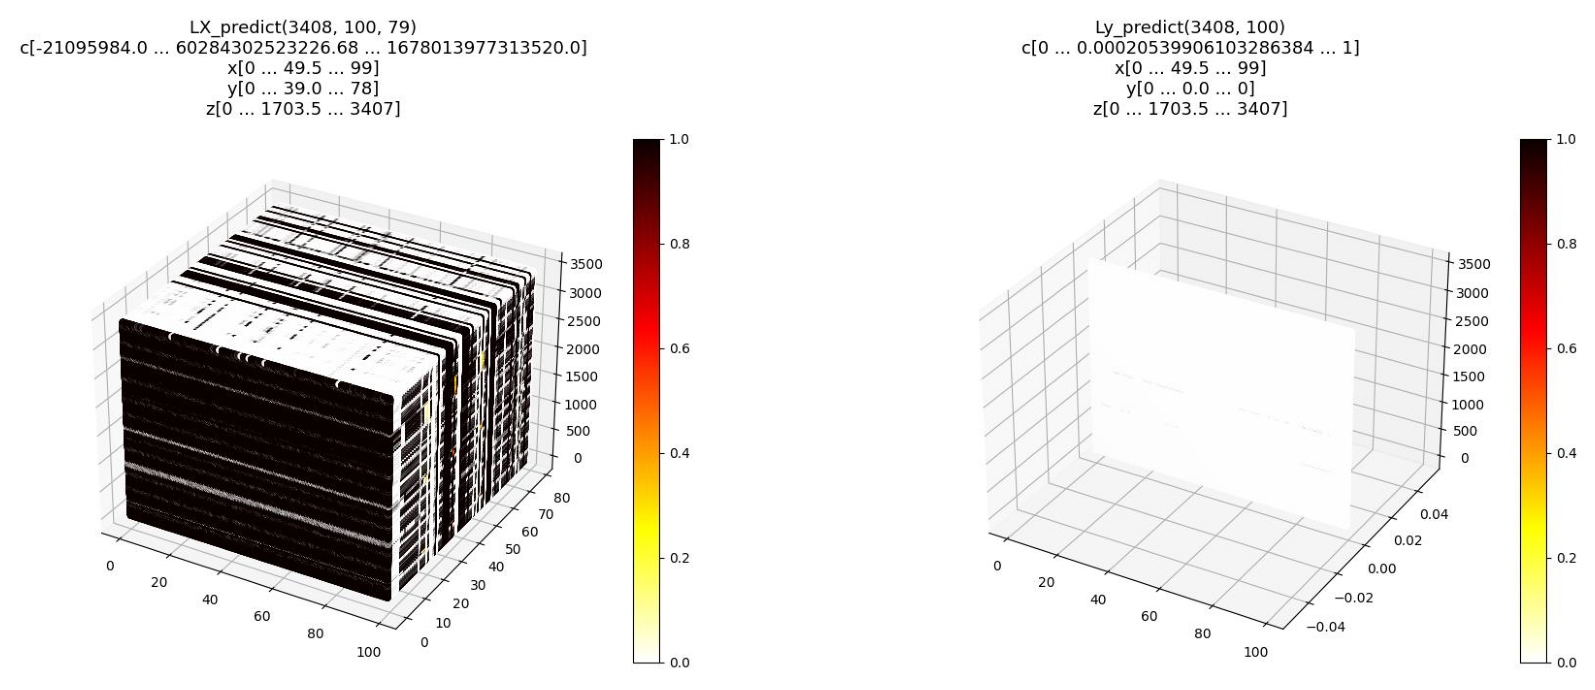

In [47]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_predict','Ly_predict'])